### Construct a Confidence Interval as a Post-process release


In [1]:
# introduced in wk3
# functions used regularly in examples

import numpy as np


def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def gaussian(shift=0., scale=1., size=None):
    """Sample from the Gaussian distribution."""
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def clamp(x, bounds):
    """Replace any x_i less than lower with lower,
           and any x_i greater than upper with upper."""
    return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    x_clamped = clamp(x, bounds)
    return np.mean(x_clamped)


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    """Release a DP mean.
    Assumes that the dataset size n is public information.
    """
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds
    # Sensitivity in terms of an absolute distance metric
    # Both the laplace and gaussian mechanisms can noise queries
    #    with sensitivities expressed in absolute distances
    sensitivity = (upper - lower) / n

    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta))
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean


def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]


def release_dp_histogram(x, epsilon, categories):
    """Release an `epsilon`-DP estimate of the counts of each of the `categories`"""
    sensitivity = 2
    scale = sensitivity / epsilon

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram

In [2]:
from scipy.stats import norm

# established in previous lectures
#from mock_dp_library import *


def ci_postprocess(release, n, bounds, epsilon, delta, alpha=0.05):
	"""Confidence interval for mean release, assuming gaussian noise."""
	lower, upper = bounds
	sensitivity = (upper - lower) / n
	scale = (sensitivity / epsilon) * np.sqrt(2 * np.log(2 / delta))

	ci_radius = norm.ppf(1 - (alpha / 2), scale=scale)
	ci_lower_bound = release - ci_radius
	ci_upper_bound = release + ci_radius

	return {"lower": ci_lower_bound, "upper": ci_upper_bound}


def ci_mean_release(x, bounds, epsilon, delta, alpha=0.05):
	"""Differentially private mean release with confidence interval metadata.
	Assumes that the dataset size is public."""
	dp_mean = release_dp_mean(x, bounds, epsilon, delta=delta, mechanism="gaussian")

	return {
		"mean": dp_mean,
		"true": bounded_mean(x, bounds),
		**ci_postprocess(release=dp_mean, n=len(x), bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)
	}

### Show performance individually for a set of confidence intervals

In [3]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

# we are demonstrating only on the educ variable
bounds = (1., 16.)
data = data['educ'].values

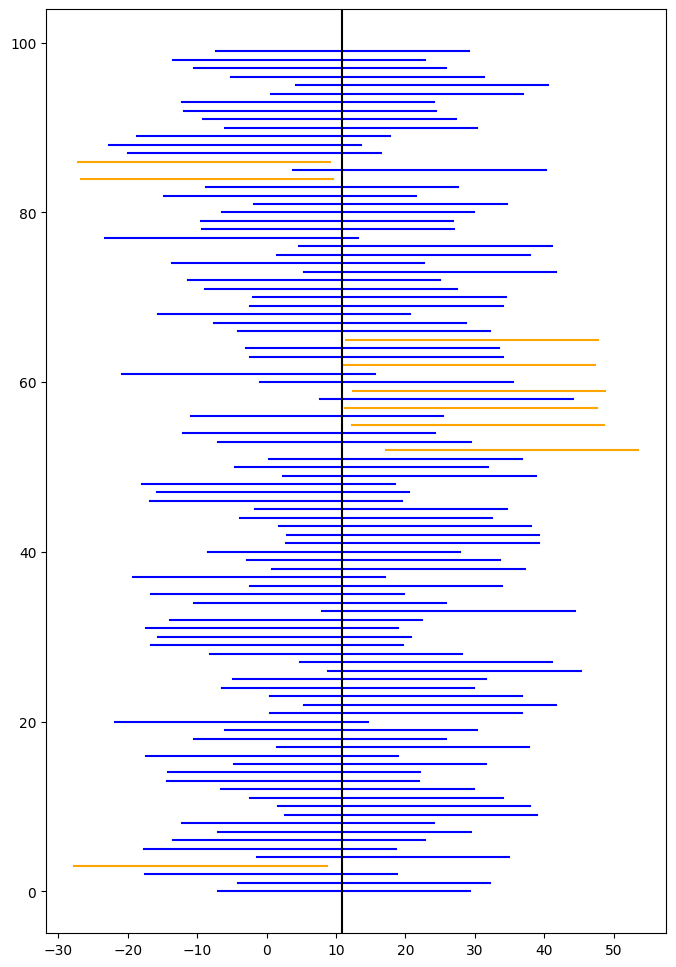

In [4]:
import matplotlib.pyplot as plt

bootdata = bootstrap(x=data, n=100)
n_sims = 100
epsilon = 0.1
delta = 1e-8
# 95% of DP CI's should cover the sample mean
alpha = 0.05

plt.figure(figsize=(8, 12))
for i in range(n_sims):
    trial = ci_mean_release(x=bootdata, bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)

    covers = trial["lower"] < trial["true"] and trial["upper"] > trial["true"]
    plt.plot((trial['lower'], trial['upper']), (i, i), '-', color="blue" if covers else "orange")

plt.axvline(x=trial["true"], color="black")



In [5]:
n_sims = 1000
population_true = data.mean(axis=0)


def simulate_coverage(epsilon, delta, sample_size, alpha):
	coverages = []
	for j in range(n_sims):
		bootdata = bootstrap(x=data, n=sample_size)
		ci_sim = ci_mean_release(x=bootdata, bounds=bounds, epsilon=epsilon, delta=delta, alpha=alpha)
		#covers_true = ci_sim["lower"] < population_true and ci_sim["upper"] > population_true # We are not covering population truth
		covers_true = ci_sim["lower"] < ci_sim["true"] and ci_sim["upper"] > ci_sim["true"]  # We are covering sample result
		coverages.append(covers_true)

	return np.mean(coverages)

# even steps in logarithmic space, rounded to 2 decimals
ep_seq = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.1), num=50), decimals=2)
sample_size = 500

agghistory = []
for epsilon in ep_seq:
	agghistory.append({"epsilon": epsilon, "coverage": simulate_coverage(epsilon, delta, sample_size, alpha)})
agghistory = pd.DataFrame(agghistory)


# even steps in logarithmic space
n_seq = np.logspace(start=np.log10(200), stop=np.log10(1500), num=15).astype(int)
epsilon = 0.1

agghistory2 = []
for sample_size in n_seq:
	agghistory2.append({"sample size": sample_size, "coverage": simulate_coverage(epsilon, delta, sample_size, alpha)})
agghistory2 = pd.DataFrame(agghistory2)



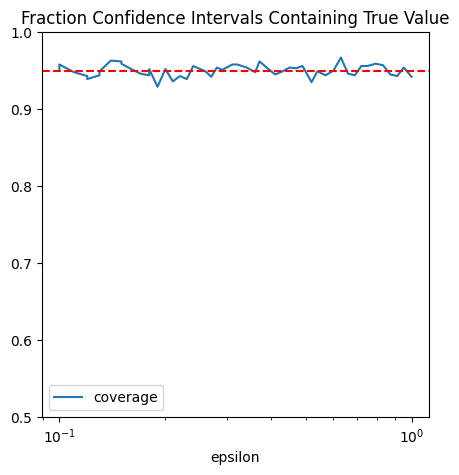

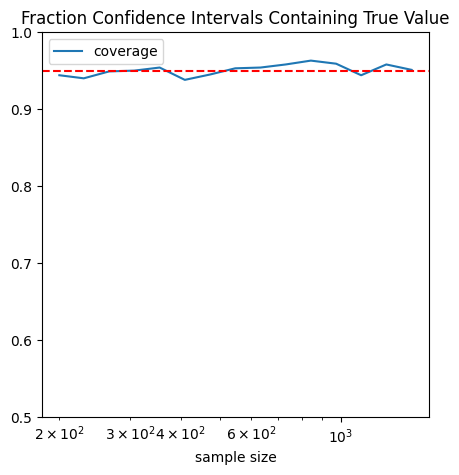

In [6]:
plt.rcParams['figure.figsize'] = [5,5]

agghistory.plot(x="epsilon", y="coverage", ylim=(0.5, 1), logx=True,
                title="Fraction Confidence Intervals Containing True Value")
plt.axhline(0.95, color="red", linestyle='--')

agghistory2.plot(x="sample size", y="coverage", ylim=(0.5, 1), logx=True,
                title="Fraction Confidence Intervals Containing True Value")
plt.axhline(0.95, color="red", linestyle='--')